---
title: Thompson sampling in practice - modifications and limitations
author: Hongsup Shin
date: 2025-01-18
description: Thompson sampling is a simple multi-armed bandit method popular among industry practitioners. In this post, I discuss its implementation, practical challenges and limitations, and how hardware verification can utilize the algorithm.
categories: [ML, verification]
format:
  html:
    code-fold: true
---

In [1]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

On the surface, hardware verification seems to be a pure exploration task because its goal is to reach near-perfect coverage while fixing bugs. However, efficient navigation of a vast design space requires informed decisions based on the past history of verification tests. 

My team has been building an ML application for efficient hardware verification that runs in parallel with existing methods. We recently had a discussion about introducing Thompson sampling, a multi-armed bandit (MAB) algorithm, popular among industry practitioners, to balance the load of the two methods. In this post, I will discuss practical challenges and limitations of Thompson sampling, and its potential use in hardware verification.

## Premise

In our application, we have two workflows (or arms). One is a supervised learning model that learns a function between the features and label of historic data. The other is the default (non-ML) simulation, which runs random tests with in a constrained design space set by verification engineers (also known as *constraint random verification (CRV)*). 

We can consider the ML model as an exploitative arm, and the random as an exploratory arm. By utilizing data from previous explorations, the model can identify bug-prone areas in a design and prioritize them in future simulations. At the same time, the random method continues exploration of a (potentially new) design space.

It is crucial to finding a right balance of the load between the two arms. If we have a greedy policy for the ML model, it becomes increasingly challenging to find new bugs, and training data becomes stale. On the other extreme, the default random method creates numerous redundant and irrelevant tests. In this context, a MAB approach is useful to dynamically control the load based on simulation results from both arms.

## Thompson sampling

Thompson sampling uses probabilistic reward functions to choose actions (arms) in a MAB setting. It's also known as *posterior sampling* because as we observe more samples (by pulling the arms), we update our posterior distribution accordingly using Bayes' rule. This way, it naturally addresses uncertainty through the probabilistic update.

In a typical beta-Bernoulli example, we start with two Beta(1, 1) distributions which are uniform priors. We draw a random sample from each distribution of both arms, and select the arm with the higher value. The beta distribution parameters are updated based on the outcome (reward) of this action: in a beta distribution, $\alpha$ and $\beta$ represent the number of successes + 1, and failures + 1. 

The figures below show how beta distributions evolve as we get more successes (top) and failures (bottom):

In [2]:
success = 0
failure = 0
n_sim = 10000
additional_successes = np.arange(5)
additional_failures = np.arange(5)

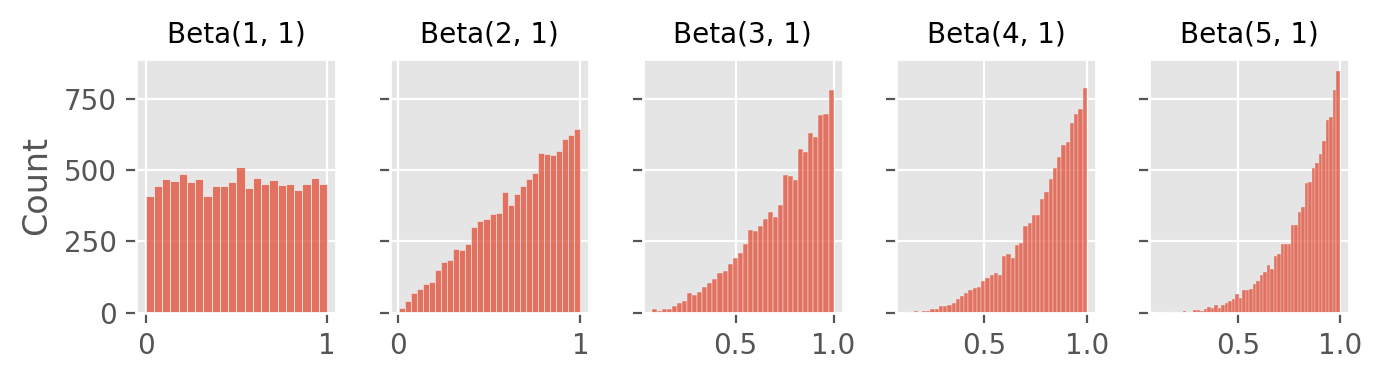

In [3]:
#| fig-cap: "Histograms of samples from beta distributions with increasing number of successes"

fig, axes = plt.subplots(1, len(additional_successes), figsize=(7, 2), sharey=True)
for i, ax in enumerate(axes):
    n_success = success + additional_successes[i]
    sim = beta.rvs(n_success + 1, failure + 1, size=n_sim)
    sns.histplot(sim, ax=ax)
    ax.set_title(f"Beta({n_success + 1}, {failure + 1})", fontsize=10)

fig.tight_layout()

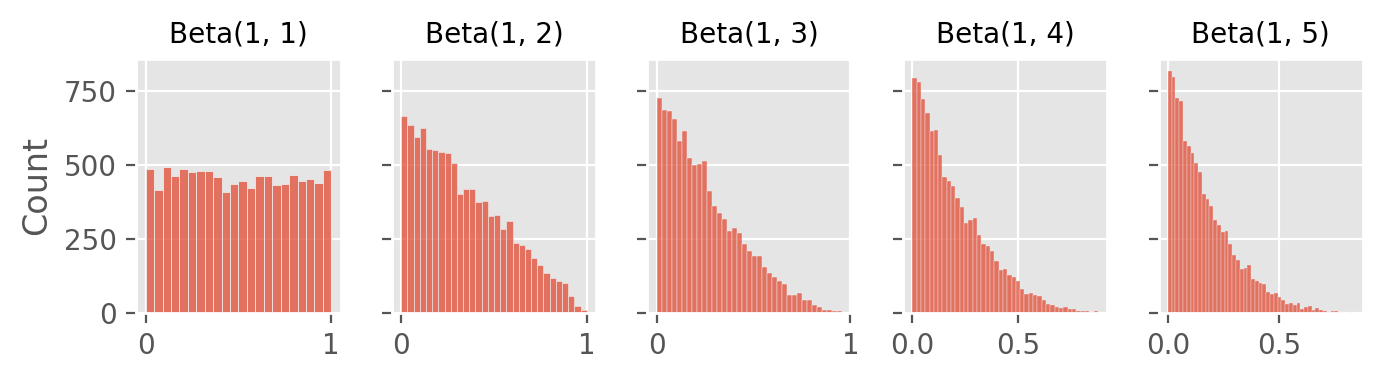

In [4]:
#| fig-cap: "Histograms of samples from beta distributions with increasing number of failures"

fig, axes = plt.subplots(1, len(additional_successes), figsize=(7, 2), sharey=True)
for i, ax in enumerate(axes):
    n_failure = success + additional_failures[i]
    sim = beta.rvs(success + 1, n_failure + 1, size=n_sim)
    sns.histplot(sim, ax=ax)
    ax.set_title(f"Beta({success + 1}, {n_failure + 1})", fontsize=10)

fig.tight_layout()

Thompson sampling's probabilistic approach helps maintain exploration of *arms*. The exploration is gradually more optimized and the uncertainty decreases as we gather more samples. How often to pull which arms (i.e., optimal allocation of load across all arms) is adjusted dynamically without manual control. 

A simple python version of Thompson sampling can be implemented like this:


```python
class ThompsonSampling:
    def __init__(self):
        # Initialize the beta distribution for both arms (uniform)
        self.alphas = [1, 1] 
        self.betas = [1, 1] 
    
    def select_arm(self):
        # Sample from both arms and return the index of the better arm
        samples = [beta.rvs(a, b, size=1)[0] for a, b in zip(self.alphas, self.betas)]
        return np.argmax(samples)

    def action(self, chosen_arm):
        # Pull the chosen arm and collect the reward
        if chosen_arm == 0:
            reward = PullArm0()
        else:
            reward = PullArm1()
        return reward
    
    def update(self):
        # Update the chosen arm's parameters based on the reward
        chosen_arm = self.select_arm()
        reward = self.action(chosen_arm)        
        if reward == 1:
            self.alphas[chosen_arm] += 1
        else:
            self.betas[chosen_arm] += 1
```

## Reducing overconfidence of arms

While the idea is simple, implementing Thompson sampling in practice requires many considerations. One of the most common issues is that a subset of arms may become too dominant, resulting in *greedy exploitation*. 

The simplest way to address is to set a *minimum exploration rate*, which guarantees a fixed amount of load dedicated to specific arms. 

```python
class ThompsonWithMinExplore:
    def __init__(self, ..., min_explore_rate=0.2):
        self.min_explore_rate = min_explore_rate

    def select_arm(self):

        if np.random.random() < self.min_explore_rate:            
            return 1 # always return a specific arm index

        samples = [beta.rvs(a, b, size=1)[0] for a, b in zip(self.alphas, self.betas)]
        return np.argmax(samples)        
```


In the verification scenario, this is a must because design exploration is crucial in verification. By allocating a minimum amount of load to exploration, we ensure that the random method continues to explore new design spaces, preventing the ML model from becoming overly greedy and missing potential new bugs.

Another approach is to adjust the probability distribution of dominant arms. Setting upper bounds of its parameters prevents their updates once they reach a threshold. 

```python
class ThompsonWithUpperBound:

    def update(self, alpha_upper_bound, beta_upper_bound):
        chosen_arm = self.select_arm()
        reward = self.action(chosen_arm)        
        if reward == 1:
            if chosen_arm == 0 and self.alphas[0] < alpha_upper_bound:
                self.alphas[0] += 1
            elif chosen_arm == 1:
                self.alphas[1] += 1
        else:
            if chosen_arm == 0 and self.betas[0] < beta_upper_bound:
                self.betas[0] += 1
            elif chosen_arm == 1:
                self.betas[1] += 1
```


Similarly, setting a time-decay on the parameters prevents arms from becoming too dominant.

```python
class ThompsonWithTimeDecay:
    def __init__(self, decay_rate):
        self.decay_rate = decay_rate
        
    def update(self):
        chosen_arm = self.select_arm()
        reward = self.action(chosen_arm)        

        # Decay before update
        self.alphas = [a * self.decay_rate for a in self.alphas]
        self.betas = [b * self.decay_rate for b in self.betas]        
        if reward == 1:
            self.alphas[chosen_arm] += 1
        else:
            self.betas[chosen_arm] += 1
```


We can consider the time-decay modification as gradually reducing the influence of older rewards. In addition to the general idea of old data becoming stale, the decay may represent bug fixes. In other words, since bugs found in the past are now fixed in the current design, executing the exact action will not produce a reward (i.e., bug).

## Dealing with rare events

Another common issue arises when reward frequency is too low. This poses two important challenges. First, in a beta-Bernoulli setup, a low frequency of events produces a beta distribution that is highly compressed towards zero with a long tail on the right side. In a situation like this where $\alpha$ is much smaller than $\beta$, we have an asymmetrical probability distribution update, meaning the probability distribution is much more sensitive to a single success than a single failure.

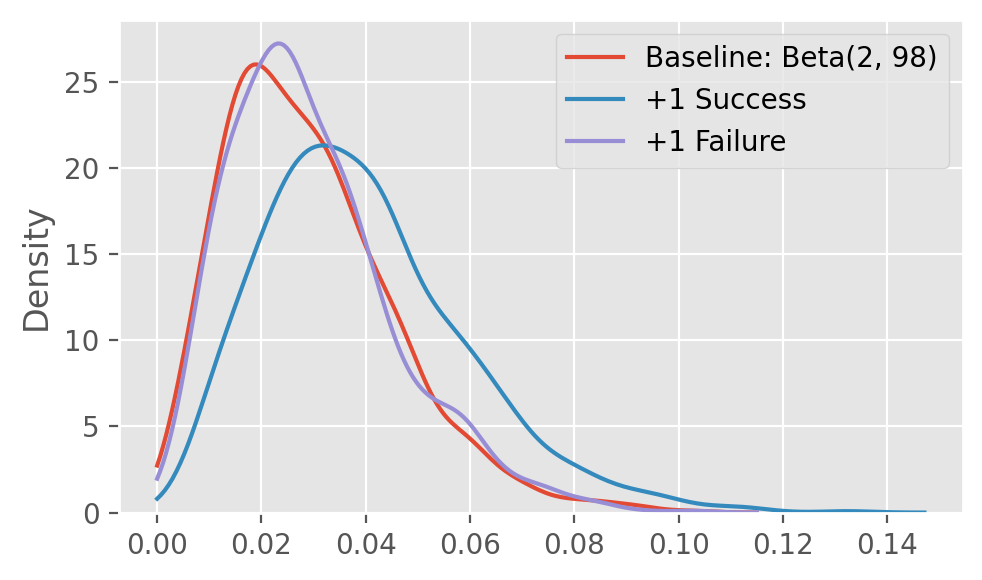

In [5]:
#| fig-align: center

success = 2
failure = 98
n_sim = 1000
sim0 = beta.rvs(success + 1, failure + 1, size=n_sim)
sim1 = beta.rvs(success + 2, failure + 1, size=n_sim)
sim2 = beta.rvs(success + 1, failure + 2, size=n_sim)

fig, ax = plt.subplots(figsize=(5, 3))
sns.kdeplot(sim0, ax=ax, clip=[0, 1], label='Baseline: Beta(2, 98)')
sns.kdeplot(sim1, ax=ax, clip=[0, 1], label='+1 Success')
sns.kdeplot(sim2, ax=ax, clip=[0, 1], label='+1 Failure')
ax.legend()
fig.tight_layout()

Another challenge is that the low frequency pushes the time horizon much further because we must collect a sizable number of samples to have good probability estimates on positive events. Depending on the time horizon limit, we may not be able to use Thompson sampling at all if the update is too slow.

With these challenges, we can first test several heuristic-based methods. First, we can start with a more optimistic prior to force early exploration of certain arms. The main downside is that wrong initial guesses are costly, and at the same time the forced-exploration effect will disappear soon without rewards. 

Second, we can consider batch-based update of parameters instead of instance-based. This can stabilize the distribution update at the price of slower learning. Literature also suggests using contextual bandit to make a more informed decision, or using a hierarchical approach to allow groups of arms share information (prior). This approach is also useful when the number of arms is large, and the cost of exploration becomes too high.

The hierarchical approach is useful in hardware verification if we have a model per design unit or test configuration, or when arms have different verification strategies such as coverage, bug hunting, soak/flood optimization, and a group of arms share a strategy. It's even possible to have two different layers of beta distributions, one at the individual level and the other at the group level, and take weighted average.

In hardware verification, the batch-based approach can have an additional edge because the tests are usually generated in batches. The fact that a typical verification process requires a huge number of tests, the issue of slower learning due to batch update might not become a huge tradeoff.

## Prior knowledge and continuous reward

In a typical Thompson sampling example, we often start with a uniform prior (e.g., Beta(1, 1)). If we already have knowledge about an arm, we can start with an informative prior. For instance, in a medical setting, if we want to compare treatment options and we already have preliminary data for certain treatments from clinical trials, we can use this to build a non-uniform prior.

If the arms have continuous rewards, gamma distribution is a good candidate because it's well-suited for modeling skewed distributions of positive rewards. The distribution has two parameters, $\alpha$, a shape parameter, and $\lambda$, a rate parameter. Using the fact that $\mu=\frac{\alpha}{\lambda}$ and $\sigma^2=\frac{\alpha}{\lambda^2}$, we can calculate and update both parameters using the mean and variance from our samples:

$$\alpha = \frac{\mu^2}{\sigma^2}$$
$$\lambda = \frac{\mu}{\sigma^2}$$

Defining a right reward function might be the most challenging part in hardware verification because the definition of verification success is often  complex and based on many heuristics and factors. First, we track the novelty of bugs, often represented as the cardinality of the set of captured bugs. Second, given multiple tests with an identical bug signature, we prefer tests with shorter runtime to save compute. Finally, the origin of a bug, whether it's from the design or other sources such as a test bench or infrastructure matters a lot.

## Limitations

Because of its simplicity, Thompson sampling is highly versatile. However, there are situations where alternative methods might be preferred. An important factor is that Thompson sampling is desirable in a situation that requires both exploration and exploitation, not just one. 

For instance, if we can get an accurate estimate from historic data, it's better to take a greed approach by eliminating low-reward arms, and stick with the best option. This is particularly important in a low-resource environment where exploration is very costly.

Other common limitations, as previously mentioned, are often about how one deals with time horizon limitations and how much information we have about the arms so that we can have good priors instead of uniform.

## Summary

We can formulate hardware verification as an MAB problem because it address the exploitation-exploration tradeoff. However, it poses a unique challenge because even if we have an oracle ML model, a greedy policy is not optimal. Ongoing exploration is still required both for pure exploration and for the model update. Hence, striking a right balance between the exploitation and exploration arms to optimize the test load remains a difficult problem. 

In this post, I explored Thompson sampling, a simple and straightforward MAB algorithm that can be applied to the verification problem. Regardless of its limitations, given the method's solid theoretical foundation and its versatility, I think it provides a great starting point for estimating the tradeoff between exploration and exploitation in hardware verification.

